In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


In [2]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
import warnings 
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [3]:
warnings.filterwarnings(action = 'ignore')

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')

In [5]:
df = train.copy()

In [6]:
X = df.drop(['id','target'],axis = 1)
Y = df['target']

In [7]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,stratify = Y, test_size = 0.2, random_state = 42)

# Optuna

### Optuna is a hyperparameter optimization framework that allows you to optimize machine learning models by tuning their hyperparameters. XGBoostClassifier can be used with Optuna to find the optimal values of its hyperparameters.

In [8]:
def objective(trial):
    # Define the hyperparameters to be optimized by Optuna
    param = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'random_state': 42
    }
    
    # Create and train the XGBoostClassifier model with the sampled hyperparameters
    model = XGBClassifier(**param)
    model.fit(x_train, y_train)
    
    # Compute the AUC score on the test set
    score = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    
    return score

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-04-09 03:47:03,101] A new study created in memory with name: no-name-75ed8f52-1858-4700-8ee9-bb0c32576c88
[I 2023-04-09 03:47:04,130] Trial 0 finished with value: 0.780846063454759 and parameters: {'n_estimators': 745, 'learning_rate': 0.000191438016129296, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.28240039837833886, 'colsample_bytree': 0.7825353899286331, 'gamma': 3.18978278067955e-05, 'reg_alpha': 6.957625067542228e-08, 'reg_lambda': 1.0504597480035399e-05}. Best is trial 0 with value: 0.780846063454759.
[I 2023-04-09 03:47:05,036] Trial 1 finished with value: 0.7397179788484137 and parameters: {'n_estimators': 719, 'learning_rate': 0.003468145470723316, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6103663554942734, 'colsample_bytree': 0.31611301702862404, 'gamma': 4.3897348863618035e-08, 'reg_alpha': 1.0303765822493702e-08, 'reg_lambda': 1.687046396758603e-06}. Best is trial 0 with value: 0.780846063454759.
[I 2023-04-09 03:47:06,134] Trial 2 finished w

In [10]:
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.8337250293772033,
params {'n_estimators': 214, 'learning_rate': 0.06491134941086518, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.36451088985563773, 'colsample_bytree': 0.36681326685511745, 'gamma': 0.13293807108488512, 'reg_alpha': 0.3954392346520341, 'reg_lambda': 0.912169037255819}


In [11]:
import optuna.visualization as vis

# Assuming that 'study' is your Optuna study object
# Visualize parameter importance
fig = vis.plot_param_importances(study)
fig.show()

In [12]:
# Visualize slice plot
fig = vis.plot_slice(study)
fig.show()

In [13]:
# Visualize parallel coordinate plot
fig = vis.plot_parallel_coordinate(study)
fig.show()

In [14]:
# Visualize optimization history plot
fig = vis.plot_optimization_history(study)
fig.show()

In [15]:
param_grid = {'n_estimators': 588, 'learning_rate': 0.010914601022630038, 
                 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.36983544183139816,
                 'colsample_bytree': 0.669791309156759, 'gamma': 0.11302676094204718, 
                 'reg_alpha': 4.04019319197943e-08, 'reg_lambda': 0.4203077089763021}

model = XGBClassifier(**param_grid)

# ROC_Curve [train,validation set]

In [16]:
model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.669791309156759, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.11302676094204718, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.010914601022630038, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=588, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=4.04019319197943e-08,
              reg_lambda=0.4203077089763021, ...)

In [17]:
train_proba = model.predict_proba(x_test)[:,1]


fpr,tpr, _ = roc_curve(y_test,train_proba)
auc_score = round(roc_auc_score(y_test,train_proba),3)

Text(0.5, 1.0, 'XGBoostClassifier ROC_CURVE')

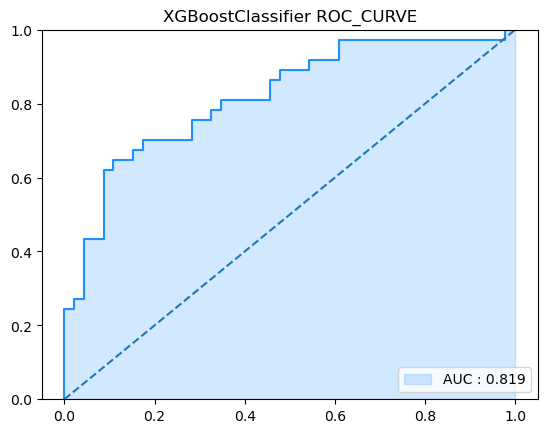

In [18]:
fig,ax = plt.subplots()

ax.plot(fpr,tpr, c = 'dodgerblue')
ax.fill_between(fpr,tpr,0, color = 'dodgerblue', alpha = 0.2,
                label = f'AUC : {auc_score}')
ax.plot([0,1],[0,1], ls = '--')
ax.set_ylim([0,1])
ax.legend(loc = 'lower right')
ax.set_title('XGBoostClassifier ROC_CURVE')

# Submission

In [19]:
model.fit(X,Y) #Train.csv
proba = model.predict_proba(test.drop('id',axis = 1))[:,1]

In [20]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')
sub['target'] = proba

In [21]:
sub.to_csv('submission.csv',index = False)

pd.read_csv('submission.csv')

,id,target
0,414,0.146284
1,415,0.751430
2,416,0.875310
3,417,0.526278
4,418,0.160539
...,...,...
271,685,0.903742
272,686,0.065855
273,687,0.735247
274,688,0.071062
